## Segment Tubulin Channel - batch process a folder of images 

In [1]:
from skimage.io import imread
import pyclesperanto_prototype as cle  # version 0.24.3
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.8
from skimage.segmentation import watershed
import napari_simpleitk_image_processing as nsitk  # version 0.4.5
from skimage.filters import median, sobel
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tif
from tqdm import tqdm
import napari
import os

In [2]:
# create napari viewer instance
if 'viewer' not in globals():
    viewer = napari.Viewer()

# a path where nuclei segmentation images were saved
path = "/Users/laura/projects/Bio-image_analysis_school_ScadsAI/prepared_dataset"

### Process one image as an example

In [3]:
filename = "aphidicolin_timelapse"

In [4]:
# read an image, which will be processed as an example
img = tif.imread(os.path.join(path, f'{filename}.tif'))

In [5]:
# viewer.add_image(img) # and then in the viewer right click on the layer - split RGB or:
viewer.add_image(
    img, 
    name=["tubulin", "actin", "nuclei"],
    colormap=["magenta", "green", "blue"],
    channel_axis=3)

[<Image layer 'tubulin' at 0x1694ea610>,
 <Image layer 'actin' at 0x1062ed610>,
 <Image layer 'nuclei' at 0x16957ccd0>]

In [6]:
filename = "aphidicolin_timelapse"

# load nuclei and actin segmentation
labels_nuclei = tif.imread(os.path.join(path, "labels_nuclei", f'{filename}_labels_dapi.tif'))
labels_actin = tif.imread(os.path.join(path, "labels_actin", f'{filename}_labels_actin.tif'))

# add segmentation layers to the viewer
# viewer.add_labels(labels_actin, name="actin_segmented")
# viewer.add_labels(labels_nuclei, name="nuclei_segmented")

In [7]:
# we get tubulin channel as a numpy array from the viewer
image = viewer.layers['tubulin'].data

# initialize a new list where we will put our segmented tubulin images
binarized_imgs = []
labels_tubulin = []

# iterate through "time" dimension
for t in tqdm(range(image.shape[0])):
    
    # get the binary image
    binary_image = nsitk.threshold_huang(image[t])
    binarized_imgs.append(binary_image)
    
    # noise removal without removing so much of the edges as gaussian blur
    noise_removed_img = cle.median_sphere(image[t], None, 1.0, 1.0, 0.0)
    
    # perform segmentation with watershed using nuclei as seeds and binary image as a mask
    labels_ws = watershed(-np.array(noise_removed_img), labels_nuclei[t], mask=binary_image)
    labels_tubulin.append(labels_ws)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.60it/s]


In [8]:
timelapse = np.stack(binarized_imgs, axis=0)
viewer.add_labels(timelapse, name="binary_mask")

<Labels layer 'binary_mask' at 0x16a1982b0>

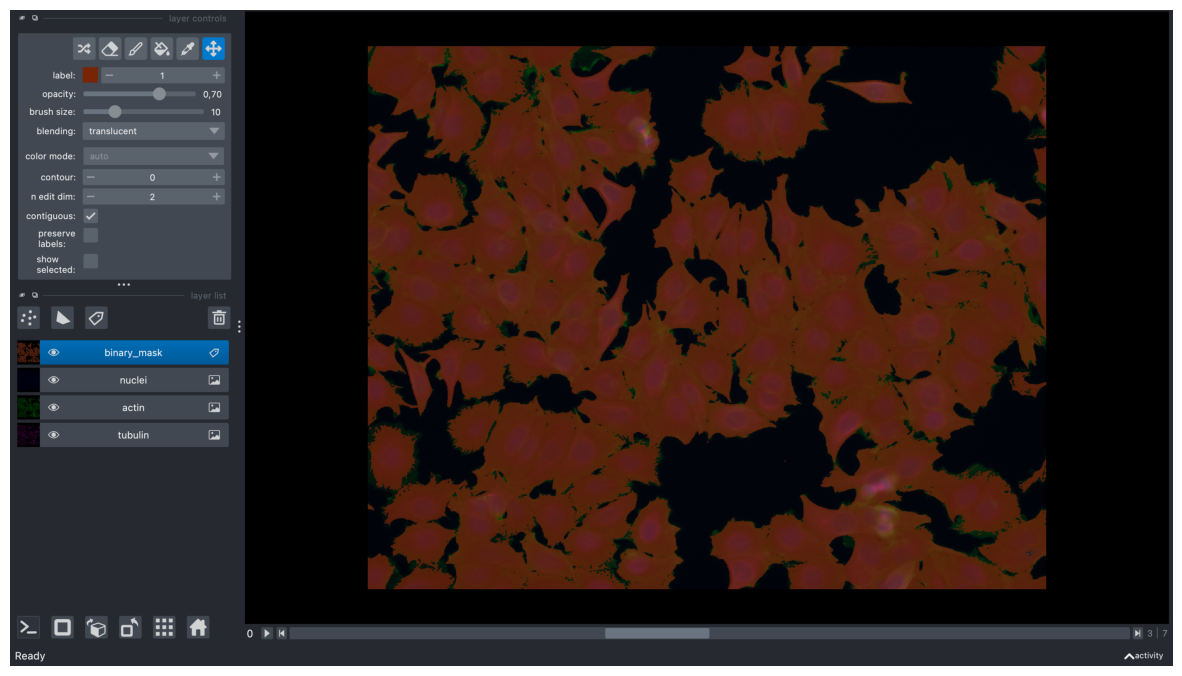

In [9]:
# note: some layers visibility and/or contrast limits were adjusted interactively in the viewer
screenshot = viewer.screenshot(canvas_only=False)

plt.figure(figsize=(15, 10))
plt.imshow(screenshot)
plt.axis('off')
plt.show()

In [10]:
labels_timelapse = np.stack(labels_tubulin, axis=0)
viewer.add_labels(labels_timelapse, name="tubulin_segmented")

<Labels layer 'tubulin_segmented' at 0x16a8f5220>

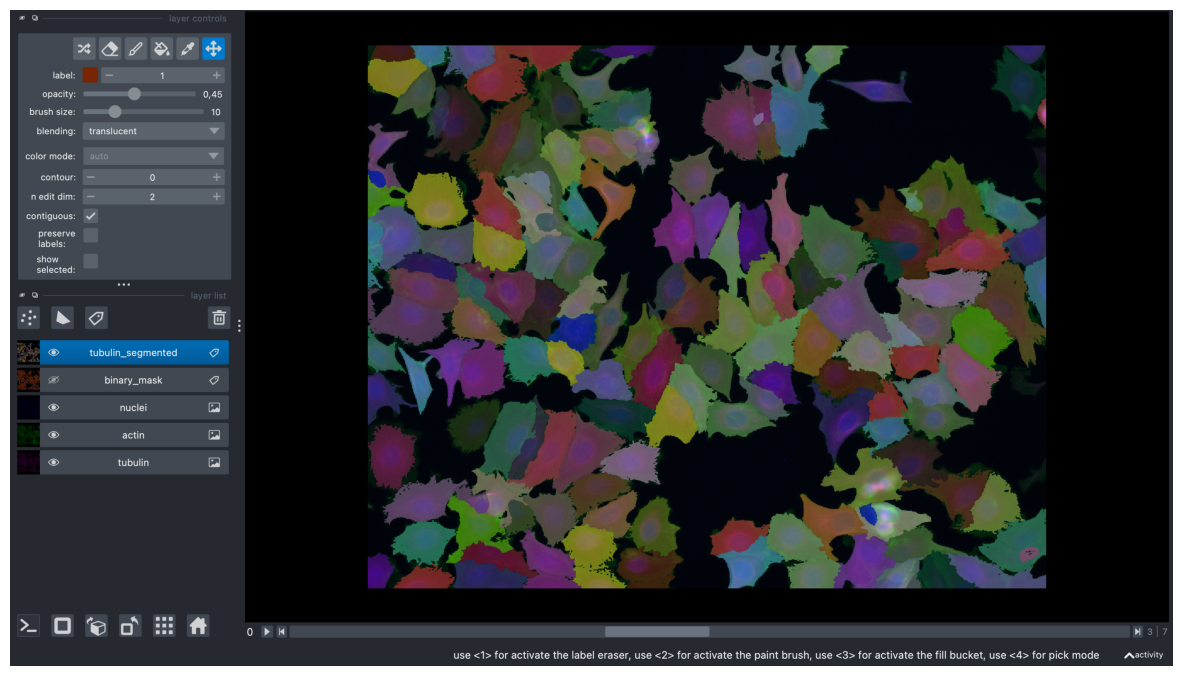

In [15]:
screenshot = viewer.screenshot(canvas_only=False)

plt.figure(figsize=(15, 10))
plt.imshow(screenshot)
plt.axis('off')
plt.show()

### Process a batch of images from a folder

In [12]:
save_path = os.path.join(path, "labels_tubulin")
nuclei_labels_path = os.path.join(path, "labels_nuclei")

In [13]:
# create save directory if it does not exist yet
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [14]:
for filename in tqdm(os.listdir(path)):
    
    if not filename.endswith("tif"):
        continue
        
    # print(f"Processing image {filename}")
    rgb_image = tif.imread(os.path.join(path, filename))
    
    # take the red (tubulin) channel only
    image = rgb_image[:, :, :, 0]
    
    # load nuclei label image
    labels_nuclei = tif.imread(os.path.join(nuclei_labels_path, f'{filename.split(".tif")[0]}_labels_dapi.tif'))
    
    # initialize an empty list where we will put obtained label images
    labels_tubulin = []
    binarized_imgs = []
    
    # iterate though the "time" dimension of the image
    for t in range(image.shape[0]):
        
        # get the binary image
        binary_image = nsitk.threshold_huang(image[t])
        binarized_imgs.append(binary_image)

        # noise removal without removing so much of the edges as gaussian blur
        noise_removed_img = cle.median_sphere(image[t], None, 1.0, 1.0, 0.0)

        # perform segmentation with watershed using nuclei as seeds and binary image as a mask
        labels_ws = watershed(-np.array(noise_removed_img), labels_nuclei[t], mask=binary_image)
        labels_tubulin.append(labels_ws)
        
    # timelapse = np.stack(binarized_imgs, axis=0)
    labels_timelapse = np.stack(labels_tubulin, axis=0)
    
    # save the labels image
    tif.imwrite(os.path.join(save_path, filename.split(".tif")[0] + "_labels_tubulin.tif"), labels_timelapse)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:18<00:00,  1.07s/it]
